# Import libraries

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift

import matplotlib.pyplot as plt

import scipy as sp
import scipy.optimize as opt
from scipy.special import wofz
from scipy import special
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema, find_peaks

import time

In [2]:
# System object
# Is defining the whole experimental setup system
class System:
    def __init__(self, 
                 lambda_0=7.95e-7, 
                 c=3e8, 
                 gamma_31=1.8850e7, 
                 gamma_21=9.425e4, 
                 b_v0=62, 
                 L=0.017, 
                 Omega_C=7.917e7, 
                 N=80000, 
                 T=2.5e-6, 
                 t_up=0.125e-6, 
                 t_down=2e-6, 
                 detuning=2.0735e8,):
        self.lambda_0 = lambda_0
        self.c = c
        self.k_0 = (2*np.pi)/(self.lambda_0)
        self.w_0 = self.k_0*self.c
        self.gamma_31 = gamma_31
        self.gamma_21 = gamma_21
        self.gamma_21_bar = self.gamma_21/self.gamma_31
        self.b_v0 = b_v0
        self.L = L
        self.Omega_C = Omega_C
        self.alpha = self.b_v0/self.L
        self.A = self.alpha*self.L / (2*np.pi)
        self.N = N
        self.T = T
        self.dt = self.T/self.N
        self.t = np.linspace(0, self.T, self.N)  # t-domain array
        self.t_up = t_up
        self.t_down = t_down
        self.detuning = detuning
        self.E_0L = (np.heaviside(self.t-self.t_up, 1) - np.heaviside(self.t-self.t_down, 1))*np.exp(1j*self.k_0*self.L)
        self.E_0Lfr = fftshift(fft(self.E_0L))
    

    # method to get wavenumber
    def k(self, w):
        return (self.w_0/self.c)*np.sqrt(1 + ((self.c*self.b_v0)/(self.w_0*self.L))*(4*(w + 1j*self.gamma_21)*self.gamma_31)/(self.Omega_C**2 - 4*(w + 1j*self.gamma_21)*(w + 1j*self.gamma_31)))


    # Real g-function
    def g(self, x):
        return np.sqrt(np.pi/8)*(1/x)*wofz(1j/(np.sqrt(8)*x))


    # quadratic fitting function
    def func1(self, Omega_C_Array, a, b, c):
        return a*Omega_C_Array**2 + b*Omega_C_Array + c


    # quartic fitting function 
    def func2(self, Omega_C_Array, a, b, c, d, e):
        return a*Omega_C_Array**4 + b*Omega_C_Array**3 + c*Omega_C_Array**2 + d*Omega_C_Array + e


    # get temporal
    def temporal(self, plot=True):
        self.f = np.linspace(-self.N/(2*self.T), self.N/(2*self.T), self.N)
        self.w = (2.0*np.pi)*self.f  
        self.w_new = np.asarray([i + self.detuning for i in self.w])
        self.trans = np.exp(1j*self.k(self.w_new)*self.L)  
        self.E_t = ifft(ifftshift(self.E_0Lfr*self.trans))
        for a in self.t:
            if a >= self.t_up:
                self.up_index = np.where(self.t==a)[0][0]
                break
        for b in self.t:
            if b >= self.t_down:
                self.down_index = np.where(self.t==b)[0][0]
                break
        # Front part of incident pulse before probe ignition
        self.part_1 = np.zeros(self.up_index)
        # size of part1
        self.part_1_size = len(self.part_1)
        # Datapoints That is Left After Front Part has Been Chosen
        self.size_left = self.N - self.part_1_size
        # Size of Time-Domain Transmitted Field From t= 0 Up Till Probe Extinction
        self.size = len(self.E_t[0: self.down_index])
        # If-Else Statements to Determine The Final Time-Domain Transmitted Field
        if self.size < self.size_left:
            self.part_2 = np.flip(np.copy(self.E_t[0: self.down_index]))
            self.part_2_size = len(self.part_2)
            self.size_left = self.N - self.part_1_size - self.part_2_size
            self.size_left = -self.size_left
            self.part_3 = np.flip(np.copy(self.E_t[self.size_left: ]))
            self.E_final = np.append(self.part_1, self.part_2)
            self.E_final = np.append(self.E_final, self.part_3)
        elif self.size == self.size_left:
            self.part_2 = np.flip(np.copy(self.E_t[0: self.down_index]))
            self.E_final = np.append(self.part_1, self.part_2)  
        elif self.size > self.size_left:
            self.size_left = self.up_index + self.down_index - self.N
            self.part_2 = np.flip(np.copy(self.E_t[self.size_left: self.down_index]))
            self.E_final = np.append(self.part_1, self.part_2)
        else:
            print("Error!!!")
        # Time-Domain Transmitted intensity
        self.I_t = np.abs(self.E_final)**2

        if plot == True:
            fig, ax = plt.subplots(1, 1)
            # plotting output field superimposed on input field at z = L
            ax.plot(self.t*1e6, 
                    np.abs(self.E_0L)**2, 
                    color = "blue",
                    linestyle = "dashed", 
                    label = f'Incident: Delta_p={self.detuning/self.gamma_31}gamma_31, Omega_c={self.Omega_C/self.gamma_31}gamma_31')   
            ax.plot(self.t*1e6, 
                    self.I_t, 
                    "r", 
                    label = "Transmitted")
            # title of plot
            # ax.set_title("Transmitted Intensity, $I_{t}(t)$ Superimposed on Incident Intensity, $I_{0}(t)$", fontsize = 25)
            # axis label
            # ax.set_xlabel("Time, t ($ \cdot 10^{-6} sec$)", fontsize = 37)
            ax.set_ylabel("Intensity, $I(t)$")
            # axis tick
            ax.tick_params(axis = "x")
            ax.tick_params(axis = "y")
            # ax.set_xticks([0.5, 1.0, 1.5, 2.0, 2.5])
            ax.set_xticks([])
            ax.set_yticks([0.0, 1.0, 2.0, 3.0, 4.0])
            # limit on x-axis
            ax.set_xlim(0, )
            # limit on y-axis
            ax.set_ylim(0, 4)
            # enable legend
            ax.legend()
            # adjusting subplots
            plt.tight_layout()
            plt.show()
        else:
            return self.I_t
    
    
    # get spectral
    def spectral(self, 
                 detuning_array=np.arange(-5.655e8, 5.655e8, 2.5e6),
                 plot=True):
        self.detuning_array = detuning_array
        self.I_s = np.array([])
        for i in self.detuning_array:
            self.temporal_temp = System(detuning=i).temporal(plot=False)
            self.I_t_extinct = np.max(self.temporal_temp[self.down_index: self.down_index+200])
            self.I_s = np.append(self.I_s, self.I_t_extinct)

        if plot == True:
            # plotting
            # Create Subplot
            fig, ax = plt.subplots(1, 1)
            # Plot I_s vs Detuning
            ax.plot(self.detuning_array/self.gamma_31, 
                    self.I_s, 
                    color = "r", 
                    label = f'Omega_c={self.Omega_C/self.gamma_31}gamma_31, b_v0={self.b_v0}')
            # Limit of y-axis
            ax.set_ylim(0, 4)
            # Plot Title
            # ax.set_title("Forward-Scattered Intensity, $I_{s}$ vs Normalized Detuning, $\Delta/\gamma_{13}$", fontsize= 27)
            ax.set_title("Forward-Scattered Intensity, $I_{s}$ vs Normalized Detuning, $\Delta/\Gamma$")
            # Label x-axis
            # ax.set_xlabel("$\Delta/\gamma_{13}$", fontsize = 33)
            ax.set_xlabel("$\Delta/\Gamma$")
            # Label y-axis
            ax.set_ylabel("$I_{s}/I_{0}$")
            # Enable Legend
            ax.legend()
            # Adjust Subplot
            plt.tight_layout()
            plt.show()
        else:
            return self.I_s

    # get 
    # def 

In [3]:
my_system = System(Omega_C=0)

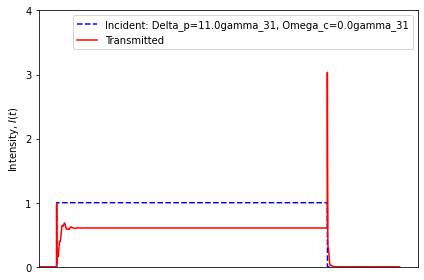

In [4]:
my_system.temporal()

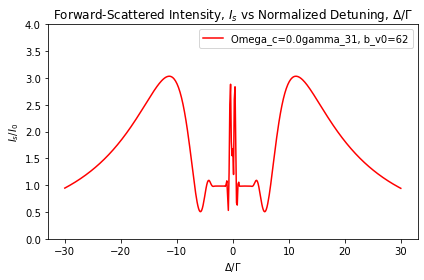

In [5]:
my_system.spectral()

In [4]:
# functions
def k(w, Omega_C):
    return (w_0/c)*np.sqrt(1 + ((c*b_v0)/(w_0*L))*(4*(w + 1j*gamma_12)*gamma_13)/(Omega_C**2 - 4*(w + 1j*gamma_12)*(w + 1j*gamma_13)))

In [7]:
# constants
lambda0 = 7.95e-7 # resonant wavelength (m)
k0 = (2*np.pi)/(lambda0) # resonant wavenumber (1/m)
c = 3e8 # vacuum speed of light (m/sec)
w_0 = k0*c # resonant angular frequency (rad/sec)

# dephasing rate between |1> (|g>) and |3> (|e>) (rad/sec)
gamma_31 = 1.8850e7
Omega_C = 4.2*gamma_31

# dephasing rate between |1> (|g>) and |2> (|c>) (rad/sec)
gamma12 = 0.005*gamma_31
gamma21 = gamma12
gamma21bar = gamma21/gamma_31

bv0 = 62 # OD
sigma = (3*(lambda0**2))/(2*np.pi) # scattering/absorption cross-section (m^2)
L = 0.017 # material thickness (m)
alpha = bv0/L
A = alpha*L / (2*np.pi)

In [8]:
# sampling parameters
N = 80000 # sampling rate/points
T = 2.5e-6 # time-domain full interval
dt = T/N # sampling interval

In [9]:
# input array
t = np.linspace(0, T, N) # t-domain array
tUp = 0.125e-6 # ignition time
tDown = 2e-6 # extinction time

# pulse
E0 = np.fft.fftshift(np.fft.fft((np.heaviside(t-tUp, 1) - np.heaviside(t-tDown, 1))*np.exp(1j*k0*L)))

In [12]:
# detuning array
N1 = 100
detuningArray = np.linspace(0, 20, N1)*gamma_31

# empty b0 array
N2 = 100
OmegaCArray = np.linspace(0, 20, N2)*gamma_31

# empty I_s array
IsArray = np.zeros((N1, N2))

# angular frequency
w = (2.0*np.pi)*np.linspace(-N/(2*T), N/(2*T), N)

In [11]:
# detuned angular frequency
wNew = np.sum(np.array(np.meshgrid(w, detuningArray)), axis=0)

In [ ]:
# transfer function
trans = np.zeros((N2, N1, N), dtype='complex_')

for m in range(N2): 
    trans[m] = np.exp(1j*k(wNew, OmegaCArray[m])*L)
    
trans = trans*E0

In [ ]:
for m in range(0, N2):
    print(m, end='\r')
    for n in range(0, N1):        
        # time-domain transmitted field
        E = np.fft.ifft(np.fft.ifftshift(trans[m,n]))

        # finding element index where probe ignition and extinction occurs
        upIndex = np.min(np.where(t >= tUp))
        downIndex = np.min(np.where(t >= tDown))
        
        # front part of incident pulse before probe ignition
        part1 = np.zeros(upIndex)
            
        # size of part1
        part1Size = len(part1)
        
        # datapoints that is left after front part has been chosen
        sizeLeft = N - part1Size
        
        # size of time-domain transmitted field from t=0 up till probe extinction
        size = len(E[0: downIndex])
        
        # if-else statements to determine the final time-domain transmitted field
        if size < sizeLeft:
            part2 = np.flip(np.copy(E[0:downIndex]))
            part2Size = len(part2)
            sizeLeft = N - part1Size - part2Size
            sizeLeft = -sizeLeft
            part3 = np.flip(np.copy(E[sizeLeft:]))
            Efinal = np.append(part1, part2)
            Efinal = np.append(Efinal, part3)
        elif size == sizeLeft:
            part2 = np.flip(np.copy(E[0:downIndex]))
            Efinal = np.append(part1, part2)  
        elif size > sizeLeft:
            sizeLeft = upIndex + downIndex - N
            part2 = np.flip(np.copy(E[sizeLeft:downIndex]))
            Efinal = np.append(part1, part2)
        
        # time-domain transmitted intensity
        It = np.abs(Efinal)**2
            
        # finding max time-domain transmitted intensity
        Is = np.max(It[downIndex: downIndex+200])
            
        # appending Isarray
        IsArray[n, m] = Is

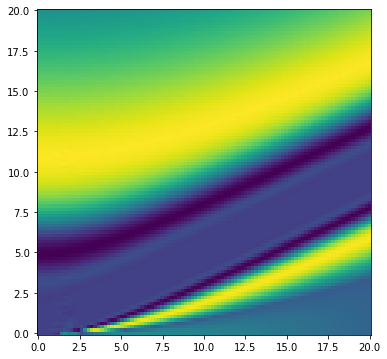

In [15]:
x = np.linspace(0, 20, 100)
y = np.linspace(0, 20, 100)

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
axs.pcolormesh(x, y, IsArray)